## 0. Import packages

In [1]:
import pandas as pd
import gzip
import math
from tqdm import tqdm
from itertools import chain, combinations
from Association import Association
from math import sqrt
tqdm.pandas() #for progres_apply etc.

## 1. Load data from previous step

In [2]:
seed_index = 0

In [3]:
import pickle
train_df = pickle.load(open(f"pickle_dumps/train_df_{seed_index}.p", "rb"))
tests_df = pickle.load(open(f"pickle_dumps/test_df_{seed_index}.p", "rb"))

article_train_df = pickle.load(open(f"pickle_dumps/article_train_df_{seed_index}.p", "rb"))
article_test_df = pickle.load(open(f"pickle_dumps/article_test_df_{seed_index}.p", "rb"))

In [4]:
train_df

,item_id,user_id
0,"[300, 924, 2877, 1588, 192, 35, 3596, 1531, 24...",0
1,"[5277, 1179, 1897, 141, 2825, 169, 1053, 1936,...",1
2,"[1206, 55, 323, 440, 58, 3946, 698, 54, 3106, ...",2
3,"[1198, 2839, 342, 2052, 332, 1132, 2512, 475, ...",3
4,"[2083, 126, 106, 2249, 345, 4934, 669, 1957, 0...",4
...,...,...
62977,[0],62977
62978,[3],62978
62979,[198],62979
62980,[14],62980


If we plot a disrtibution of the length per user, we see that most data leans towards a length of 100 items

34.33992251754469


(array([2.4807e+04, 1.4433e+04, 8.5120e+03, 5.1410e+03, 3.3080e+03,
        1.9260e+03, 1.1580e+03, 8.7100e+02, 6.1000e+02, 4.5800e+02,
        3.4300e+02, 2.5100e+02, 2.2100e+02, 1.6900e+02, 1.0000e+02,
        9.9000e+01, 7.7000e+01, 5.9000e+01, 5.6000e+01, 3.9000e+01,
        4.7000e+01, 4.9000e+01, 1.9000e+01, 2.5000e+01, 1.6000e+01,
        2.7000e+01, 1.7000e+01, 1.3000e+01, 7.0000e+00, 1.7000e+01,
        1.2000e+01, 9.0000e+00, 1.3000e+01, 7.0000e+00, 1.0000e+01,
        7.0000e+00, 3.0000e+00, 1.0000e+00, 7.0000e+00, 3.0000e+00,
        4.0000e+00, 2.0000e+00, 5.0000e+00, 9.0000e+00, 3.0000e+00,
        3.0000e+00, 3.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00]),
 array([  1.  ,  15.24,  29.48,  43.72,  57.96,  72.2 ,  86.44, 100.68,
        114.92, 129.16, 143.4 , 157.64, 171.88, 186.12, 200.36, 214.6 ,
        228.84, 243.08, 257.32, 271.56, 285.8 , 300.04, 314.28, 328.52,
        342.76, 357.  , 371.24, 385.48, 399.72, 413.96, 428.2 , 442.44,
        456.68, 470.92, 485.16

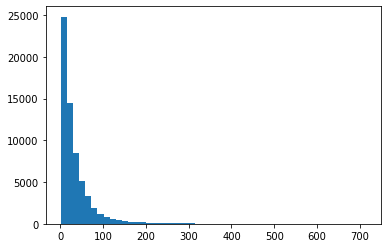

In [5]:
import matplotlib.pyplot as plt
x = [len(i) for i in train_df["item_id"]]
print(sum(x)/len(x))
plt.hist(x, bins=50)

In [6]:
article_train_df

,item_id,user_id
0,300,"[0, 7, 11, 17, 18, 23, 24, 32, 36, 49, 50, 65,..."
1,924,"[0, 3, 7, 16, 19, 20, 23, 24, 29, 42, 49, 69, ..."
2,2877,"[0, 4, 9, 27, 36, 49, 93, 95, 104, 133, 143, 1..."
3,1588,"[0, 10, 12, 13, 16, 20, 23, 32, 34, 39, 47, 49..."
4,192,"[0, 3, 10, 11, 12, 16, 17, 19, 20, 21, 24, 28,..."
...,...,...
7090,7163,[45058]
7091,7162,[50504]
7092,6679,[51768]
7093,6962,[52641]


The transposed dataframe that is used for building user association rules has only a few items most of the time. this is not that important because of the way user associations are build.

304.8339675828048


(array([6.389e+03, 3.150e+02, 1.280e+02, 7.100e+01, 4.400e+01, 2.300e+01,
        1.500e+01, 1.900e+01, 1.100e+01, 1.300e+01, 1.200e+01, 1.100e+01,
        5.000e+00, 5.000e+00, 1.000e+00, 4.000e+00, 2.000e+00, 2.000e+00,
        6.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 0.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00]),
 array([1.000000e+00, 5.818200e+02, 1.162640e+03, 1.743460e+03,
        2.324280e+03, 2.905100e+03, 3.485920e+03, 4.066740e+03,
        4.647560e+03, 5.228380e+03, 5.809200e+03, 6.390020e+03,
        6.970840e+03, 7.551660e+03, 8.132480e+03, 8.713300e+03,
        9.294120e+03, 9.874940e+03, 1.045576e+04, 1.103658e+04,
        1.161740e+04, 1.219822e+04, 1.277904e+04, 1.3359

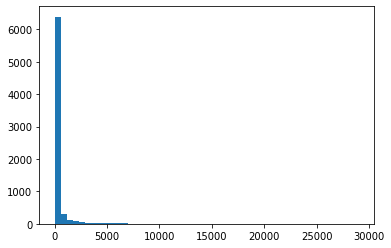

In [7]:
x = [len(i) for i in article_train_df["user_id"]]
print(sum(x)/len(x))
plt.hist(x, bins=50)

In [8]:
tests_df

,item_id,user_id
0,"[682, 561, 4927, 817, 217, 266, 53, 3062, 185,...",0
1,"[213, 1900, 4025, 1456, 3141, 1438, 1757, 459,...",1
2,"[2460, 1989, 1301, 1857, 2507, 104, 56, 215, 1...",2
3,"[681, 1804, 643, 729, 805, 915, 1029, 716, 193...",3
4,"[3, 1407, 1938, 540, 1006, 2205, 2291, 1746, 3...",4
...,...,...
62977,[2],62977
62978,[2],62978
62979,[5],62979
62980,[137],62980


In [9]:
data = train_df.set_index("user_id").to_dict()["item_id"]
article_data = article_train_df.set_index("item_id").to_dict()["user_id"]

test_users = tests_df["user_id"].tolist()

## 2. Functions or building association rules

In [10]:
# def eclat(prefix, minsup, items, start=True):
#     """
#     Basic eclat implementation for finding frequent itemsets
#     """
#     frequents = []
#     while items:
#         i,itids = items.pop()
#         isupp = len(itids)
#         if isupp >= minsup:
#             frequents.append((frozenset(prefix + [i]), isupp))
#             suffix = [] 
#             for j, ojtids in items:
#                 jtids = set(itids) & set(ojtids)
#                 if len(jtids) >= minsup:
#                     suffix.append((j,jtids))
#             frequents.extend(eclat(prefix+[i], minsup, sorted(suffix, key=lambda item: len(item[1]), reverse=True), False))
#     return frequents

In [11]:
# def subsets(itemset, include_empty_set=False):
#     """ List all strict subsets of an itemset without the empty set or with the empty set if include_empty_set=True
#         subsets({1,2,3}) --> [{1}, {2}, {3}, {1, 2}, {1, 3}, {2, 3}]
#     """
#     s = list(itemset)
#     if include_empty_set:
#         return map(set, chain.from_iterable(combinations(s, r) for r in range(0, len(s) + 1)))
#     return map(set, chain.from_iterable(combinations(s, r) for r in range(1, len(s))))

In [12]:
# def deriveRules(itemsets, minconf, test_users):
#     """ Returns all rules with conf >= minconf that can be derived from the itemsets.
#         Return: list of association rules in the format: [(antecedent, consequent, supp, conf), ...]
#     """
#     search_items = dict(itemsets)
#     rules = []
#     for item_set, supp in tqdm(itemsets):
#         if len(item_set) > 1: # itemsets with one frequent item are unable to generate a rule
#             for subset in subsets(item_set):  # for each subset generate a rule
#                 antecedent = frozenset(subset)
#                 consequent = item_set - subset
#                 if len(consequent)== 1: # only keep rules with one item in the consequent
#                     conf = supp / search_items[antecedent]
#                     if conf >= minconf: # assure confidence of the rule is high enough
#                         # if test_users are passed, only generate rules with one of the test users in the consequent
#                         if test_users:
#                             if list(consequent)[0] in test_users:
#                                 rules.append(Association(antecedent, consequent, conf, supp))
#                         else:
#                             rules.append(Association(antecedent, consequent, conf, supp))
                        

#     return rules

In [13]:
def convertTo(df):
    with open("eclat_in.txt", "w") as f:
        tmp = df.items()
        for item in tmp:
            s = ' '.join([str(elem) for elem in item[1]])
            f.write(s + "\n")
            

def convertFrom():
    res = []
    with open("eclat_out.txt", "r") as f:
        for line in f:
            line = line.strip()
            tmp = line.split(" <- ")
            consequent = [tmp[0]]
            tmp = tmp[1].split(" (")
            antecedent = tmp[0].split(" ")
            tmp = tmp[1].strip(')').split(", ")
            sup = tmp[0]
            conf = tmp[1]
            antecedent = list(map(int, antecedent))
            consequent = list(map(int, consequent))
            res.append(Association(antecedent, consequent, float(conf), float(sup)))
    
    return res

# convertFrom()

In [14]:
def genRules(min_conf, minsup, df):
    print("---writing data---")
    convertTo(df)
    print("---building rules---")
    !eclat.exe -tr -Z -s-$minsup eclat_in.txt eclat_out.txt
    print("---reading data---")
    rules = convertFrom()

#     print("---Mining frequent itemsets---")
#     !eclat.exe -Z -s-200 eclat_in.txt eclat_out.txt
#     frequents = convertFrom()
#     print("---Generating rules---")
#     rules = deriveRules(frequents, min_conf, test_users)
    return rules 

#     print("---Mining frequent itemsets---")

#     frequent_itemsets = eclat([], minsup, sorted(data.items(), key=lambda item: len(item[1]), reverse=True))
#     print(f"{len(frequent_itemsets)} frequent itemsets")
#     c = 0
#     for f in frequent_itemsets:
#         if len(f[0]) == 1:
#             c += 1
#     print(f"{c} frequent itemsets of length 1")
#     print("---Generating rules---")
#     return deriveRules(frequent_itemsets, min_conf, test_users)

## 3. Build association rules

### Article association rules
Build rules of the form:
`Item1 and Item2 -> Item3`

In [15]:
%%time

print(len(data))

# Build the article association rules with a minimum support of 50 and minimum confidence of 0.85
article_assos_rules = genRules(0.0, 100, data)

62982
---writing data---
---building rules---
all: 584066
  0: 0
  1: 0
  2: 8
  3: 1877
  4: 37394
  5: 168964
  6: 233937
  7: 118316
  8: 21988
  9: 1566
 10: 16
---reading data---


eclat.exe - find frequent item sets with the eclat algorithm
version 5.22 (2020.06.15)        (c) 2002-2020   Christian Borgelt
reading eclat_in.txt ... [7095 item(s), 62982 transaction(s)] done [0.11s].
filtering, sorting and recoding items ... [2296 item(s)] done [0.00s].
sorting and reducing transactions ... [60757/62982 transaction(s)] done [0.05s].
finding frequent item sets ... done [255.68s].
writing eclat_out.txt ... [584066 rule(s)] done [11.01s].


Wall time: 4min 31s


In [16]:
len(article_assos_rules)

584066

In [17]:
%%time

# print number of rules with item 3 in the lhs
counter = 0
for r in article_assos_rules:
    if 3 in r.left:
        counter += 1
counter

Wall time: 69 ms


79686

In [18]:
# print number of rules with a support greater than 150
for r in article_assos_rules:
    if int(r.s) > 500:
        print(r)

Conf: 83.71	Supp: 743.00	 {95, 75, 0} => {38}
Conf: 82.18	Supp: 752.00	 {95, 75, 1} => {38}
Conf: 80.52	Supp: 503.00	 {95, 75, 2} => {38}
Conf: 81.38	Supp: 827.00	 {95, 75, 3} => {38}
Conf: 82.23	Supp: 591.00	 {95, 75, 4} => {38}
Conf: 83.20	Supp: 637.00	 {95, 75, 6} => {38}
Conf: 83.11	Supp: 604.00	 {95, 75, 7} => {38}
Conf: 83.07	Supp: 561.00	 {95, 75, 8} => {38}
Conf: 82.31	Supp: 554.00	 {95, 75, 10} => {38}
Conf: 81.49	Supp: 616.00	 {95, 75, 12} => {38}
Conf: 81.11	Supp: 561.00	 {95, 75, 14} => {38}
Conf: 81.66	Supp: 567.00	 {95, 75, 15} => {38}
Conf: 80.86	Supp: 606.00	 {95, 75, 18} => {38}
Conf: 81.80	Supp: 544.00	 {95, 75, 22} => {38}
Conf: 80.94	Supp: 619.00	 {95, 75, 26} => {38}
Conf: 81.99	Supp: 1294.00	 {95, 75} => {38}
Conf: 81.00	Supp: 521.00	 {165, 95} => {38}
Conf: 80.88	Supp: 523.00	 {178, 95} => {38}
Conf: 86.22	Supp: 1277.00	 {126, 0} => {38}
Conf: 86.36	Supp: 755.00	 {126, 1, 0} => {38}
Conf: 84.13	Supp: 1248.00	 {126, 1} => {38}
Conf: 86.23	Supp: 530.00	 {126, 2, 0}

Conf: 86.27	Supp: 670.00	 {126, 50} => {95}
Conf: 83.30	Supp: 563.00	 {126, 48} => {95}
Conf: 86.51	Supp: 697.00	 {126, 54} => {95}
Conf: 87.19	Supp: 601.00	 {126, 52} => {95}
Conf: 86.13	Supp: 620.00	 {126, 58} => {95}
Conf: 84.91	Supp: 530.00	 {126, 63} => {95}
Conf: 85.08	Supp: 583.00	 {126, 65} => {95}
Conf: 88.16	Supp: 583.00	 {126, 61} => {95}
Conf: 85.09	Supp: 597.00	 {126, 67} => {95}
Conf: 85.50	Supp: 593.00	 {126, 68} => {95}
Conf: 85.54	Supp: 581.00	 {126, 73} => {95}
Conf: 85.69	Supp: 643.00	 {126, 75, 0} => {95}
Conf: 87.42	Supp: 628.00	 {126, 75, 1} => {95}
Conf: 87.06	Supp: 711.00	 {126, 75, 3} => {95}
Conf: 85.30	Supp: 517.00	 {126, 75, 4} => {95}
Conf: 84.82	Supp: 560.00	 {126, 75, 6} => {95}
Conf: 85.69	Supp: 517.00	 {126, 75, 7} => {95}
Conf: 87.88	Supp: 528.00	 {126, 75, 12} => {95}
Conf: 84.03	Supp: 501.00	 {126, 75, 14} => {95}
Conf: 86.44	Supp: 509.00	 {126, 75, 18} => {95}
Conf: 87.69	Supp: 520.00	 {126, 75, 26} => {95}
Conf: 87.47	Supp: 1109.00	 {126, 75} => {9

### User association rules
Build rules of the form: `User1 and User2 -> User3`

This builds rules that represent the relation and similarity between users.

In [19]:
%%time
# Build the user association rules with a minimum support of 40 and minimum confidence of 0.0
user_assos_rules = genRules(0.0,50,article_data)


---writing data---
---building rules---
all: 356017
  0: 0
  1: 0
  2: 9
  3: 4255
  4: 24427
  5: 113071
  6: 212797
  7: 1458
---reading data---


eclat.exe - find frequent item sets with the eclat algorithm
version 5.22 (2020.06.15)        (c) 2002-2020   Christian Borgelt
reading eclat_in.txt ... [62982 item(s), 7095 transaction(s)] done [0.15s].
filtering, sorting and recoding items ... [16883 item(s)] done [0.01s].
sorting and reducing transactions ... [6720/7095 transaction(s)] done [0.02s].
finding frequent item sets ... done [85.61s].
writing eclat_out.txt ... [356017 rule(s)] done [1.16s].


Wall time: 1min 29s


In [20]:
for i in range(5):
    print(type(user_assos_rules[i].right[0]))
    print(type(test_users[i]))


<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>


In [21]:
%%time

user_assos_rules = list(filter(lambda x: any([i in test_users for i in x.right]), user_assos_rules))

Wall time: 834 ms


In [22]:
# print numebr of generated rules
print(len(user_assos_rules))

356017


See for how much test users we were able to create association rules and how many

In [23]:
# %%time

# corr = {}
# for r in tqdm(user_assos_rules):
#     for user in test_users:
#         if user in list(r.right):
#             if user in corr:
#                 corr[user] += 1
#             else:
#                 corr[user] = 1

In [24]:
# print(len(test_users))
# print(len(corr))
# print(corr)

## 4. Normalize support / confidence to better use it later

In [25]:
"""
minc = 1
maxc = 0

mins = 9999999999999
maxs = -9999999999999
for a in article_assos_rules:
    if a.c < minc:
        minc = a.c
    if a.c > maxc:
        maxc = a.c
    
    if a.s < mins:
        mins = a.s
    if a.s > maxs:
        maxs = a.s
            
for a in article_assos_rules:
    a.c = (a.c - minc) / (maxc - minc)
    a.s = (a.s - mins) / (maxs - mins)
    # temp score that's just lhs + weighted average of c, s
    a.score = len(a.left) + sqrt(pow(a.c, 2) + pow(a.s, 2))

"""

article_assos_rules = sorted(article_assos_rules, key = lambda x: x.score, reverse=True)
for i in article_assos_rules[:20]:
    print(i)


Conf: 81.20	Supp: 117.00	 {14, 9, 8, 7, 6, 3, 0} => {1}
Conf: 82.35	Supp: 102.00	 {15, 9, 8, 6, 5, 4, 3} => {1}
Conf: 80.43	Supp: 138.00	 {15, 11, 10, 9, 6, 3} => {0}
Conf: 80.00	Supp: 115.00	 {18, 13, 11, 10, 8, 4, 2} => {0}
Conf: 80.00	Supp: 105.00	 {18, 14, 9, 8, 6, 3, 0} => {1}
Conf: 80.39	Supp: 153.00	 {18, 15, 13, 10, 8, 2} => {0}
Conf: 81.73	Supp: 104.00	 {18, 15, 13, 10, 8, 2, 1} => {0}
Conf: 80.58	Supp: 103.00	 {18, 14, 12, 10, 7, 6, 4, 0} => {15}
Conf: 80.19	Supp: 106.00	 {18, 16, 15, 10, 8, 3, 0} => {12}
Conf: 80.30	Supp: 132.00	 {18, 19, 13, 12, 10, 8} => {0}
Conf: 80.45	Supp: 133.00	 {17, 12, 11, 7, 6, 4} => {0}
Conf: 81.00	Supp: 100.00	 {17, 13, 12, 11, 5, 4} => {1}
Conf: 80.00	Supp: 100.00	 {17, 15, 9, 8, 4, 3, 0} => {12}
Conf: 80.58	Supp: 103.00	 {17, 15, 13, 11, 5, 4} => {1}
Conf: 82.00	Supp: 100.00	 {17, 19, 11, 9, 7, 6} => {0}
Conf: 81.51	Supp: 119.00	 {17, 18, 13, 10, 6, 3} => {0}
Conf: 80.47	Supp: 128.00	 {20, 11, 10, 7, 6, 4} => {0}
Conf: 82.35	Supp: 102.00	 {21, 

## 5. Store the association rules as pickle file for further use

In [26]:
import pickle
pickle.dump(article_assos_rules, open("pickle_dumps/article_rules.p", "wb"))
pickle.dump(user_assos_rules, open("pickle_dumps/user_rules.p", "wb"))